<a href="https://colab.research.google.com/github/Amasha03/Customer_Churn_Prediction/blob/main/notebooks/03_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CM2604 Machine Learning

In [16]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,confusion_matrix,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
#Load dataset
df=pd.read_csv('/content/drive/MyDrive/ML/coursework/preprocessed_data.csv')

In [3]:
"""
#Data Cleaning
#Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(),inplace=True)

#Encode target
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

binary_cols=['Partner','Dependents','PhoneService','PaperlessBilling','gender']
for col in binary_cols:
  df[col]=df[col].map({'Yes':1,'No':0,'Female':1,'Male':0})

#Drop customerID
df.drop('customerID',axis=1,inplace=True)
"""


/tmp/ipython-input-3917039961.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(),inplace=True)


In [4]:
"""
#One-Hot Encode Categorical Variables

categorical_cols=['Contract','InternetService','PaymentMethod','MultipleLines','OnlineBackup','OnlineSecurity','TechSupport','StreamingTV','StreamingMovies']

df=pd.get_dummies(df,columns=categorical_cols)
"""


In [5]:
"""
#############################
df['AvgMonthlyCharge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['HasPremiumInternet'] = np.where(df['InternetService_Fiber optic'] == 1, 1, 0)
df['LongTenure'] = (df['tenure'] > 12).astype(int)
df['HighMonthlyCharge'] = (df['MonthlyCharges'] > 70).astype(int)
df['HighRiskCustomer'] = (
    (df['MonthlyCharges'] > 70) &
    (df['Contract_Month-to-month'] == 1) &
    (df['TechSupport_No'] == 1)
).astype(int)
"""


In [19]:
#Select important features
selected_features=[
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'PaperlessBilling',
    'Contract_Two year',
    'Contract_One year',
    'InternetService_Fiber optic',
    'OnlineBackup_Yes',
    'TechSupport_No',
    'PaymentMethod_Electronic check',
    'OnlineSecurity_Yes',
    'OnlineSecurity_No',
    'StreamingTV_No',
    'SeniorCitizen',
    'Contract_Month-to-month',
    'PaymentMethod_Credit card (automatic)',
    'InternetService_DSL',
    'StreamingTV_Yes',
    'StreamingMovies_Yes',
    'TechSupport_Yes'

]

X=df[selected_features]
y=df['Churn']

In [20]:
#Train-Test Splits
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [21]:
#Hyperparameter Tuning
dtree=DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42)

param_grid={
    'criterion':['gini','entropy'],
    'max_depth':[3,5,7,10,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'max_features': [None,'sqrt']
}

grid_search=GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train,y_train)

#Best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [22]:
#Evaluate Model
best_dtree=grid_search.best_estimator_
y_pred=best_dtree.predict(X_test)

#Predicted probabilities for the positive class (Churn=1)
y_prob=best_dtree.predict_proba(X_test)[:,1]

#Accuracy
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

#AUC Score
auc=roc_auc_score(y_test,y_prob)
print(f"AUC Score: {auc*100:.2f}%")

print("\nClassification Report: \n",classification_report(y_test,y_pred))
print("\nConfusion Matrix: \n",confusion_matrix(y_test,y_pred))


Accuracy: 73.42%
AUC Score: 79.91%

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.73      0.80      1033
           1       0.50      0.75      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.75      1407


Confusion Matrix: 
 [[753 280]
 [ 94 280]]


In [23]:
best_params={
    'criterion':'gini',
    'max_depth':5,
    'max_features':'sqrt',
    'min_samples_leaf':1,
    'min_samples_split':2,
    'random_state':42
}
dtree_final=DecisionTreeClassifier(**best_params)

#Train on the training set
dtree_final.fit(X_train,y_train)

#Predict and evaluate
y_pred_final=dtree_final.predict(X_test)
y_prob_final=dtree_final.predict_proba(X_test)[:,1]

print("Accuracy:",accuracy_score(y_test,y_pred_final))
print("AUC Score:",roc_auc_score(y_test,y_prob_final))

print("\nClassification Report: \n",classification_report(y_test,y_pred_final))
print("\nConfusion Matrix: \n",confusion_matrix(y_test,y_pred_final))

Accuracy: 0.7803837953091685
AUC Score: 0.8029517888295863

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1033
           1       0.63      0.43      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.68      1407
weighted avg       0.76      0.78      0.77      1407


Confusion Matrix: 
 [[939  94]
 [215 159]]


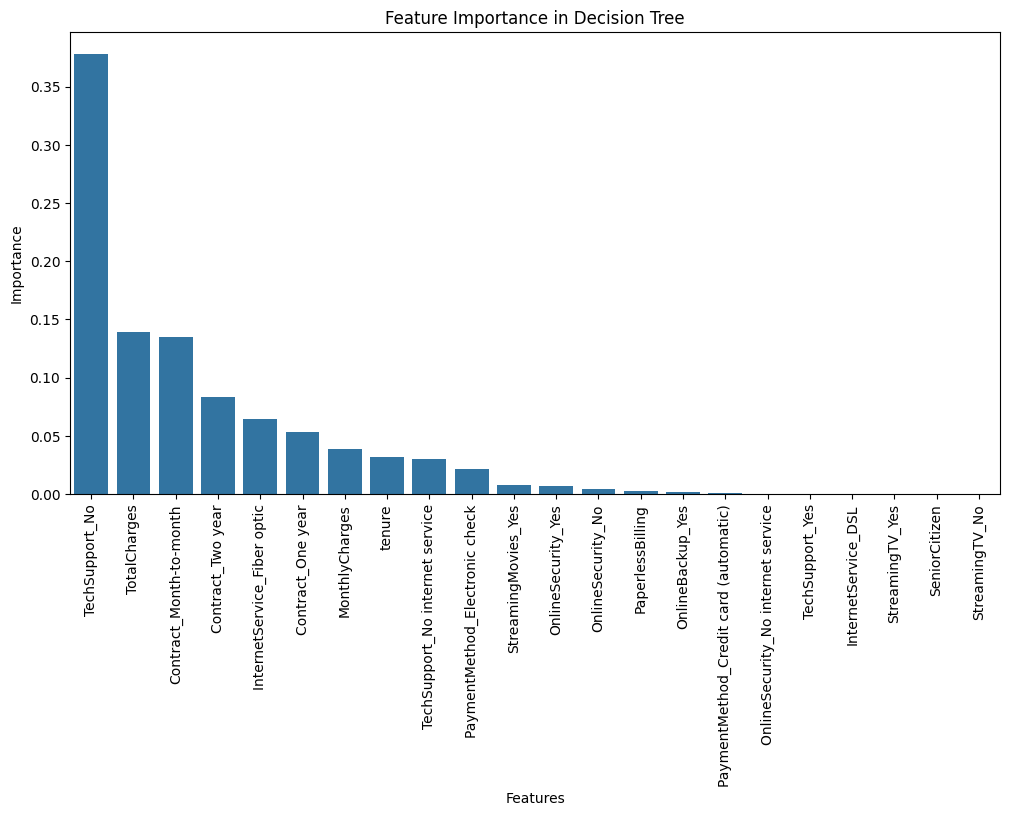

In [12]:
#Feature Importance Visualization
importances=best_dtree.feature_importances_
indices=np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=[selected_features[i] for i in indices],y=importances[indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.xticks(rotation=90)
plt.show()